In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

import sys
sys.path.append("../project_functions/")
import ad_functions as adfns
import ad_crnn_functions as adcrn


import pandas as pd
import numpy as np
import cv2
from keras.regularizers import l1_l2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import (
    Input, 
    Conv2D, 
    MaxPooling2D, 
    Reshape, 
    Bidirectional, 
    LSTM, 
    Dense, 
    BatchNormalization, 
    Activation,
    Dropout, 
    Softmax, 
    TimeDistributed,
    Flatten
)



## Load the Dataset

In [3]:
data = pd.read_csv('bw_600k_created_files.csv')

In [4]:
# Load the dataset and split it into train and test sets
def load_images(file_names):
    images = []
    for file_name in file_names:
        print(file_name)
        full_path_image = ("./digits_600k/"+file_name+".png")
        # print(full_path_image)
        # image = cv2.imread(os.path.join('./bw_digits', file_name, '.png'), cv2.IMREAD_GRAYSCALE)
        image = cv2.imread(full_path_image, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (32, 32))
        image = np.expand_dims(image, axis=-1)
        images.append(image)
    return np.array(images)


In [ ]:

X = load_images(data['filename'].values)
y = data['digit'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Normalize images


In [6]:
X_train = X_train / 255.0
X_test = X_test / 255.0

## One-hot encode labels


In [7]:
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

## Define the CRNN model

In [10]:
def create_crnn_model(input_shape, num_classes):
    inputs = Input(input_shape)

    # Convolutional layers
    x = Conv2D(32, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Reshape for LSTM
    x = Reshape(target_shape=(4, 4*128))(x)

    # Bidirectional LSTM layers
    x = Bidirectional(LSTM(256, return_sequences=True))(x)
    x = TimeDistributed(Dense(128, activation='relu'))(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)

    # Dense layer for classification with regularization
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)

    model = Model(inputs=inputs, outputs=outputs)

    return model

In [11]:
input_shape = (32, 32, 1)
num_classes = 10

crnn_model = create_crnn_model(input_shape, num_classes)

## Train the CRNN model


In [12]:
crnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


batch_size = 64
epochs = 25

history = crnn_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))


Epoch 1/25
7500/7500 [==============================] - 77s 9ms/step - loss: 0.0081 - accuracy: 0.9981 - val_loss: 3.6493e-04 - val_accuracy: 1.0000
Epoch 2/25
7500/7500 [==============================] - 72s 10ms/step - loss: 9.3472e-04 - accuracy: 0.9999 - val_loss: 2.4429e-04 - val_accuracy: 1.0000
Epoch 3/25
7500/7500 [==============================] - 73s 10ms/step - loss: 6.6262e-04 - accuracy: 1.0000 - val_loss: 4.3205e-04 - val_accuracy: 1.0000
Epoch 4/25
7500/7500 [==============================] - 71s 9ms/step - loss: 5.1426e-04 - accuracy: 1.0000 - val_loss: 4.4005e-04 - val_accuracy: 1.0000
Epoch 5/25
7500/7500 [==============================] - 72s 10ms/step - loss: 5.4761e-04 - accuracy: 1.0000 - val_loss: 5.9040e-04 - val_accuracy: 1.0000
Epoch 6/25
7500/7500 [==============================] - 73s 10ms/step - loss: 4.9328e-04 - accuracy: 1.0000 - val_loss: 5.0504e-04 - val_accuracy: 1.0000
Epoch 7/25
7500/7500 [==============================] - 73s 10ms/step - loss: 4.43

In [13]:

# Test the CRNN model
score = crnn_model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

3750/3750 [==============================] - 15s 4ms/step - loss: 2.3007e-04 - accuracy: 1.0000
Test loss: 0.00023007365234661847
Test accuracy: 1.0


## Save the Model

In [14]:
model_file = "CRNN_digits_model_bw_600k_extra_layers.h5"
crnn_model.save(model_file)

## Load the Model

In [4]:
# from tensorflow.keras.models import load_model
model_file = "CRNN_digits_model_bw_600k.h5"
crnn_model = load_model(model_file)

## Testing the Model against SIPA 09 Cropped

In [28]:
def preprocess_digit_gray(digit_image, target_size=(32, 32)):
    digit_image = cv2.resize(digit_image, target_size)
    digit_image = cv2.cvtColor(digit_image, cv2.COLOR_RGB2GRAY)
    digit_image = digit_image.astype("float32") / 255.0
    digit_image = np.expand_dims(digit_image, axis=-1)
    digit_image = np.expand_dims(digit_image, axis=0)
    return digit_image

(300, 1182)


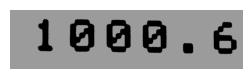

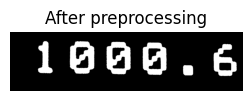

1/1 [==============================] - 3s 3s/step
[[2.9624731e-04 1.1142182e-05 4.9733685e-06 4.6243554e-04 7.6925680e-06
  4.9409293e-02 7.1332060e-08 9.4980270e-01 5.2570940e-06 1.2678341e-07]]


In [5]:
image_path = "./cropped_images/9/S09_F03_Cropped.png"

img = cv2.imread(image_path)
img = adfns.invert_thresh(img)
print(img.shape)
adfns.show_img(img, 3)


preprocess_image = adcrn.preprocess_image(img)

adfns.show_img(preprocess_image, 3, title="After preprocessing")

digit_images = adcrn.extract_digits(preprocess_image)
predictions = []

# preprocessed_digit_b = preprocess_digit_gray(digit_images[0])
preprocessed_digit_a = adcrn.preprocess_digit(digit_images[0])

prediction = crnn_model.predict(preprocessed_digit_a)

print(prediction)


In [26]:
print(preprocessed_digit.shape)

(1, 32, 32, 3)


(247, 726)


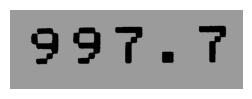

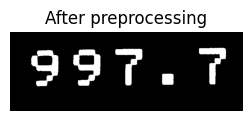

1/1 [==============================] - 0s 15ms/step
Predicted number: 66070
[6, 6, 0, 7, 0]


In [15]:
image_path = "./cropped_images/9/S09_F01_Cropped.png"

img = cv2.imread(image_path)
img = adfns.invert_thresh(img)
print(img.shape)
adfns.show_img(img, 3)

preprocess_image = adcrn.preprocess_image(img)

adfns.show_img(preprocess_image, 3, title="After preprocessing")

digit_images = adcrn.extract_digits(preprocess_image)
predictions = []

for digit_image in digit_images:
    preprocessed_digit = adcrn.preprocess_digit(digit_image)
    prediction = crnn_model.predict(preprocessed_digit)
    digit_prediction = np.argmax(prediction)
    # print("Predicted digit:", digit_prediction)
    predictions.append(digit_prediction)

print("Predicted number:", ''.join(map(str, predictions)))
print(predictions)

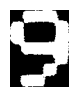

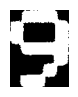

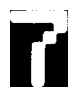

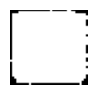

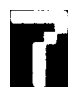

In [16]:
for digit_image in digit_images:
    adfns.show_img(digit_image, 1)

In [17]:
def ad_process_and_predict_digits(crnn_model, directory_path):
    file_list = os.listdir(directory_path)

    for file_name in file_list:
        image_path = os.path.join(directory_path, file_name)
        img = cv2.imread(image_path)
        img = adfns.invert_thresh(img)
        print(img.shape)
        adfns.show_img(img, 3)

        preprocess_image = adcrn.preprocess_image(img)

        adfns.show_img(preprocess_image, 3, title="After preprocessing")

        inverted_image = cv2.bitwise_not(preprocess_image)

        adfns.show_img(inverted_image, 3, title="Inverted")


        digit_images = adcrn.extract_digits_bow(inverted_image)
        predictions = []

        for digit_image in digit_images:
            adfns.show_img(digit_image, 1)
            preprocessed_digit = adcrn.preprocess_digit(digit_image)
            prediction = crnn_model.predict(preprocessed_digit)
            digit_prediction = np.argmax(prediction)
            predictions.append(digit_prediction)

        print("Predicted number:", "".join(map(str, predictions)))
        print(predictions)


(247, 726)


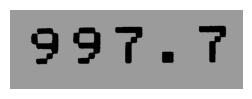

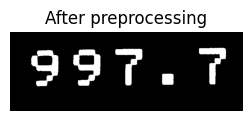

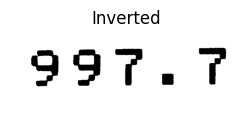

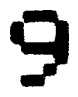

1/1 [==============================] - 0s 22ms/step


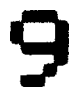

1/1 [==============================] - 0s 16ms/step


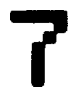

1/1 [==============================] - 0s 15ms/step


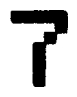

1/1 [==============================] - 0s 15ms/step
Predicted number: 9977
[9, 9, 7, 7]
(275, 696)


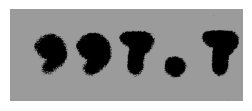

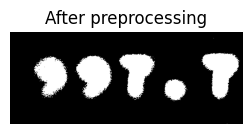

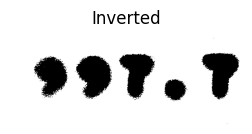

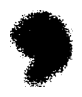

1/1 [==============================] - 0s 17ms/step


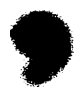

1/1 [==============================] - 0s 19ms/step


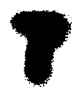

1/1 [==============================] - 0s 18ms/step


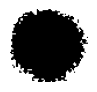

1/1 [==============================] - 0s 22ms/step


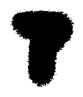

1/1 [==============================] - 0s 17ms/step
Predicted number: 99701
[9, 9, 7, 0, 1]
(300, 1182)


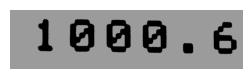

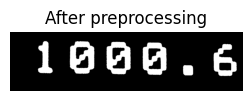

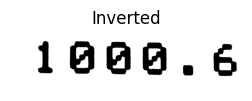

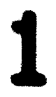

1/1 [==============================] - 0s 14ms/step


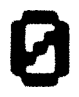

1/1 [==============================] - 0s 16ms/step


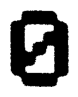

1/1 [==============================] - 0s 16ms/step


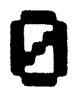

1/1 [==============================] - 0s 17ms/step


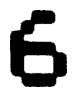

1/1 [==============================] - 0s 19ms/step
Predicted number: 10006
[1, 0, 0, 0, 6]
(484, 1236)


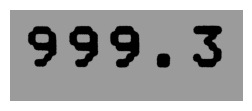

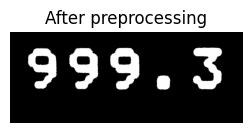

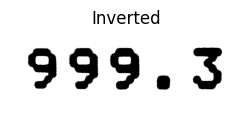

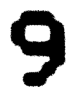

1/1 [==============================] - 0s 15ms/step


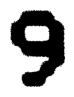

1/1 [==============================] - 0s 21ms/step


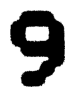

1/1 [==============================] - 0s 18ms/step


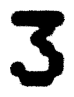

1/1 [==============================] - 0s 18ms/step
Predicted number: 9993
[9, 9, 9, 3]
(272, 844)


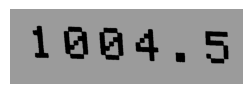

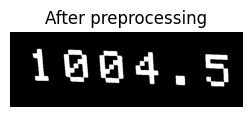

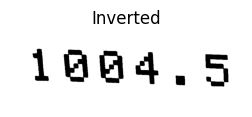

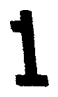

1/1 [==============================] - 0s 17ms/step


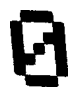

1/1 [==============================] - 0s 15ms/step


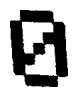

1/1 [==============================] - 0s 16ms/step


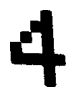

1/1 [==============================] - 0s 16ms/step


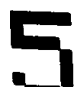

1/1 [==============================] - 0s 18ms/step
Predicted number: 10045
[1, 0, 0, 4, 5]
(223, 761)


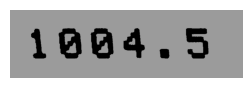

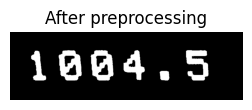

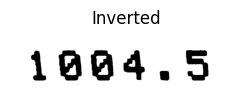

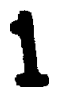

1/1 [==============================] - 0s 15ms/step


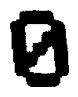

1/1 [==============================] - 0s 15ms/step


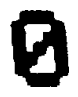

1/1 [==============================] - 0s 16ms/step


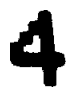

1/1 [==============================] - 0s 16ms/step


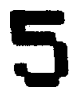

1/1 [==============================] - 0s 16ms/step
Predicted number: 10045
[1, 0, 0, 4, 5]
(178, 586)


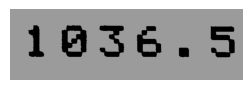

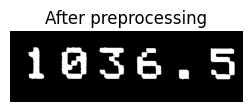

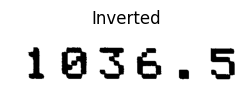

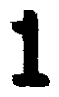

1/1 [==============================] - 0s 20ms/step


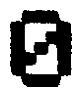

1/1 [==============================] - 0s 16ms/step


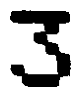

1/1 [==============================] - 0s 15ms/step


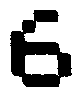

1/1 [==============================] - 0s 19ms/step


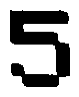

1/1 [==============================] - 0s 15ms/step
Predicted number: 10365
[1, 0, 3, 6, 5]
(285, 1081)


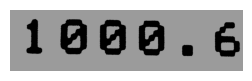

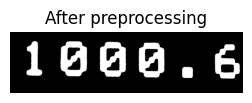

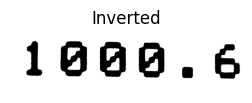

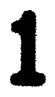

1/1 [==============================] - 0s 14ms/step


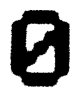

1/1 [==============================] - 0s 17ms/step


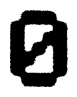

1/1 [==============================] - 0s 18ms/step


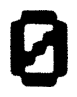

1/1 [==============================] - 0s 14ms/step


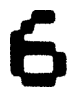

1/1 [==============================] - 0s 16ms/step
Predicted number: 10006
[1, 0, 0, 0, 6]
(273, 709)


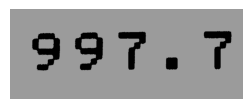

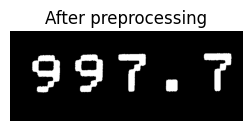

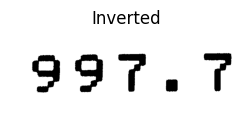

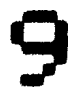

1/1 [==============================] - 0s 14ms/step


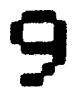

1/1 [==============================] - 0s 15ms/step


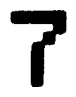

1/1 [==============================] - 0s 19ms/step


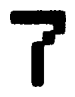

1/1 [==============================] - 0s 19ms/step
Predicted number: 9977
[9, 9, 7, 7]
(202, 594)


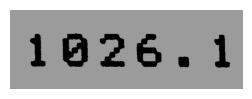

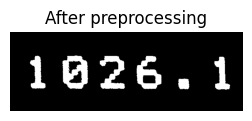

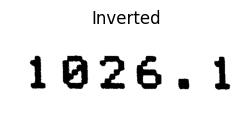

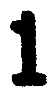

1/1 [==============================] - 0s 15ms/step


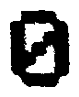

1/1 [==============================] - 0s 19ms/step


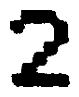

1/1 [==============================] - 0s 16ms/step


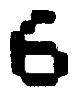

1/1 [==============================] - 0s 17ms/step


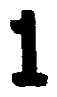

1/1 [==============================] - 0s 16ms/step
Predicted number: 10261
[1, 0, 2, 6, 1]
(162, 628)


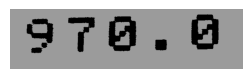

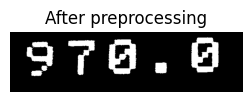

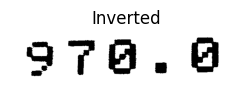

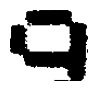

1/1 [==============================] - 0s 21ms/step


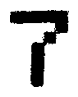

1/1 [==============================] - 0s 16ms/step


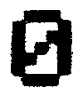

1/1 [==============================] - 0s 15ms/step


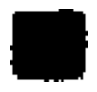

1/1 [==============================] - 0s 15ms/step


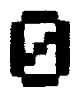

1/1 [==============================] - 0s 15ms/step
Predicted number: 07000
[0, 7, 0, 0, 0]
(200, 614)


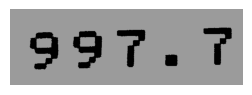

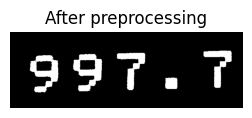

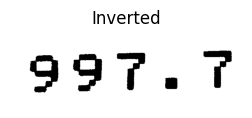

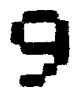

1/1 [==============================] - 0s 16ms/step


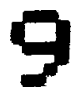

1/1 [==============================] - 0s 17ms/step


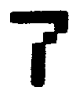

1/1 [==============================] - 0s 22ms/step


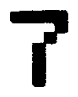

1/1 [==============================] - 0s 17ms/step
Predicted number: 9977
[9, 9, 7, 7]
(227, 775)


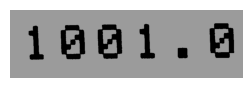

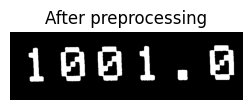

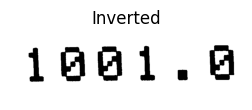

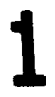

1/1 [==============================] - 0s 16ms/step


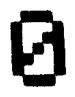

1/1 [==============================] - 0s 17ms/step


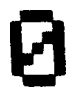

1/1 [==============================] - 0s 16ms/step


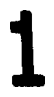

1/1 [==============================] - 0s 18ms/step


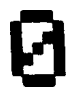

1/1 [==============================] - 0s 16ms/step
Predicted number: 10010
[1, 0, 0, 1, 0]
(333, 793)


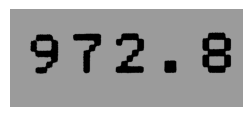

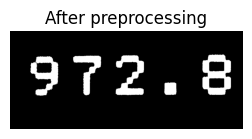

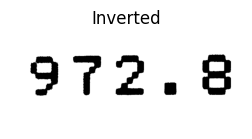

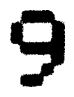

1/1 [==============================] - 0s 14ms/step


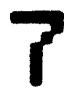

1/1 [==============================] - 0s 17ms/step


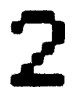

1/1 [==============================] - 0s 45ms/step


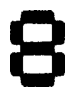

1/1 [==============================] - 0s 18ms/step
Predicted number: 9728
[9, 7, 2, 8]
(182, 623)


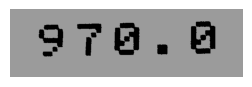

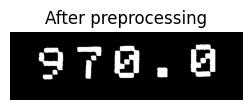

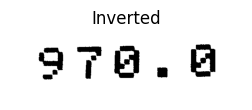

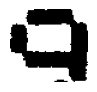

1/1 [==============================] - 0s 18ms/step


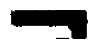

1/1 [==============================] - 0s 16ms/step


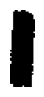

1/1 [==============================] - 0s 17ms/step


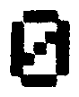

1/1 [==============================] - 0s 16ms/step


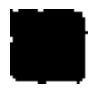

1/1 [==============================] - 0s 15ms/step


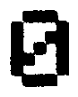

1/1 [==============================] - 0s 17ms/step
Predicted number: 050000
[0, 5, 0, 0, 0, 0]
(214, 674)


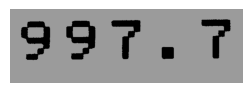

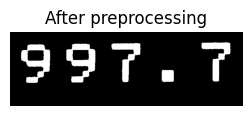

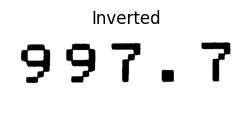

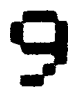

1/1 [==============================] - 0s 16ms/step


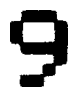

1/1 [==============================] - 0s 18ms/step


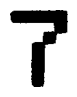

1/1 [==============================] - 0s 18ms/step


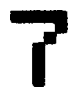

1/1 [==============================] - 0s 17ms/step
Predicted number: 9977
[9, 9, 7, 7]
(192, 535)


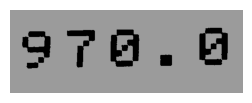

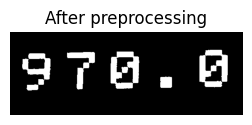

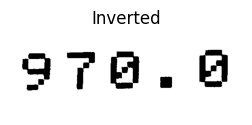

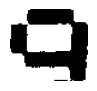

1/1 [==============================] - 0s 16ms/step


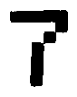

1/1 [==============================] - 0s 31ms/step


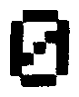

1/1 [==============================] - 0s 14ms/step


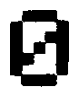

1/1 [==============================] - 0s 14ms/step
Predicted number: 0700
[0, 7, 0, 0]
(211, 694)


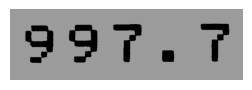

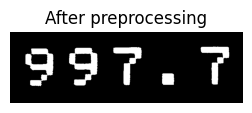

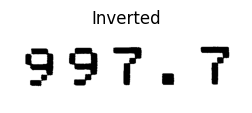

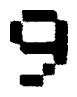

1/1 [==============================] - 0s 16ms/step


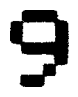

1/1 [==============================] - 0s 15ms/step


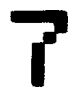

1/1 [==============================] - 0s 15ms/step


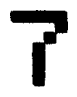

1/1 [==============================] - 0s 15ms/step
Predicted number: 9977
[9, 9, 7, 7]
(211, 601)


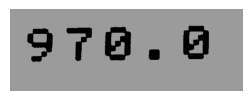

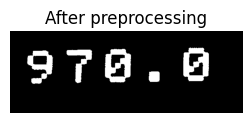

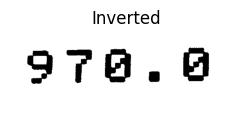

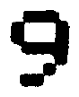

1/1 [==============================] - 0s 16ms/step


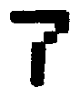

1/1 [==============================] - 0s 17ms/step


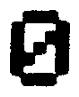

1/1 [==============================] - 0s 18ms/step


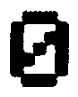

1/1 [==============================] - 0s 17ms/step
Predicted number: 9700
[9, 7, 0, 0]
(184, 589)


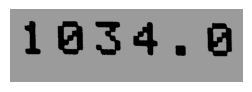

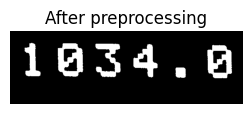

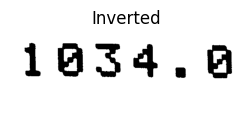

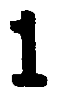

1/1 [==============================] - 0s 15ms/step


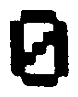

1/1 [==============================] - 0s 18ms/step


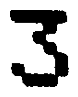

1/1 [==============================] - 0s 18ms/step


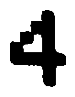

1/1 [==============================] - 0s 15ms/step


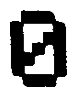

1/1 [==============================] - 0s 17ms/step
Predicted number: 10340
[1, 0, 3, 4, 0]


In [18]:
ad_process_and_predict_digits(crnn_model, "./cropped_images/9/")